## Graph neural networks: Use machine learning to find a shortest path in weighted directed graphs

Consider a directed, connected graph $G=(V,E)$ where $V$ is a set of nodes and $E=\{(s_i, r_i, w_i)\mid i=1,\dots, m\}$ where $s_i, r_i \in V$ are sender and receiver nodes for edge $i$ and $w_i$ is a positive weight. Consider a path $P = (s_1, r_1, w_1), \dots, (s_k, r_k, w_k)$ with $r_{i+1} = s_i$. Let its length be defined as $L(P) = \sum_{j=1}^k w_j$.
For convenience, let $P_{s,t}$ define a path start starts in node $s$ and ends in node $t$.

Goal: Design a simple graph neural network that predicts a shortest path between two given nodes $s, t \in V$ in a given graph, i.e. $$argmin_{P_{s,t}} L(P_{s,t}).$$

Below you will already find code that
- generates random graphs and converts them to training examples and targets
- visualizes a graph
- basic code pieces for model construction and training 

In [ ]:
import sys
!{sys.executable} -m pip install numpy==1.19.5 --force-reinstall #fixes "Cannot convert a symbolic Keras input/output to a numpy array." error

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy import spatial

#for reproducibilty 
np.random.seed(0)
tf.random.set_seed(0)

In [17]:
# a method that generates a connected weighted random graph and finds a
# shortest path between two random nodes in this graph
def make_graph(n_min = 10, n_max=20, p_edge=0.1):
    
    #number of nodes in the generated graph
    num_nodes = np.random.randint(n_min, n_max)

    # use networkx to sample a random graph.
    rand_graph = nx.fast_gnp_random_graph(num_nodes, p_edge)
    
    # sample a random tree
    rand_tree = nx.generators.trees.random_tree(num_nodes)
    
    # compose graph and tree to make sure the returned graph will always be connected
    G = nx.compose_all((rand_graph, rand_tree))
    G = G.to_directed()
    
    #generate 2D positions for all nodes in the graph
    pos = nx.spring_layout(G)
    pos_array = np.array([pos[i] for i in range(num_nodes)])
    
    #compute all pairwise euclidean distances (based on the 2D Layout)
    distances = spatial.distance.cdist(pos_array, pos_array)
    
    #create a target graph; it will have different attributes than G
    G_target = G.copy()
    
    # put all distance weights into edge attributes.
    for i, j in G.edges():
        G.get_edge_data(i, j).setdefault(
                "distance", distances[i, j])
        G.get_edge_data(j, i).setdefault(
                "distance", distances[j, i])
        
    # here we take the 2 nodes with the greatest distance as start and target
    s,t = np.unravel_index(np.argmax(distances), distances.shape)
    if s==t: #bad case, just sample again
        make_graph(n_min, n_max, p_edge)
    nx.set_node_attributes(G, False, "start") #default case
    nx.set_node_attributes(G, {s:True}, "start") 
    nx.set_node_attributes(G, False, "target") #default case
    nx.set_node_attributes(G, {t:True}, "target") 
    
    #compute a shortest path and add attributes to G_target
    shortest_path = nx.shortest_path(G, s, t, weight="distance")
    
    nx.set_edge_attributes(G_target, 
                           False, 
                           "shortest_path") #default case
    nx.set_edge_attributes(G_target, 
                           {(i,j):True for i,j in zip(shortest_path[:-1], shortest_path[1:])}, 
                           "shortest_path")
    
    return G, G_target, pos


#draws a graph, optionally adds a given shortest path with colors
def draw_graph(G, G_target, pos, edge_widths=1.5):
    plt.rcParams["figure.figsize"] = (16,10)
    node_colors = ["green" if s
                   else
                        "orange" if t
                               else "blue" 
                   for (_,s),(_,t) in zip(G.nodes.data("start"), G.nodes.data("target"))]
    edge_colors = ["red" if p else (0,0,0,0) #< non shortest path edges are transparent
                   for _,_,p in G_target.edges.data("shortest_path")]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors)
    nx.draw_networkx_edges(G, 
                           pos, 
                           width=edge_widths, 
                           connectionstyle="arc3,rad=0.1") #draw all edges in black
    nx.draw_networkx_edges(G_target, 
                           pos, 
                           edge_color=edge_colors, 
                           width=edge_widths,
                           connectionstyle="arc3,rad=0.1") #only draw shortest path edges in red on top
    nx.draw_networkx_edge_labels(G_target,
                                 pos,
                                 edge_labels=dict([((u,v,), f"{d['distance']:.2f}") 
                                                   for u,v,d in G.edges(data=True)]),
                                 font_color='black')
    plt.show()

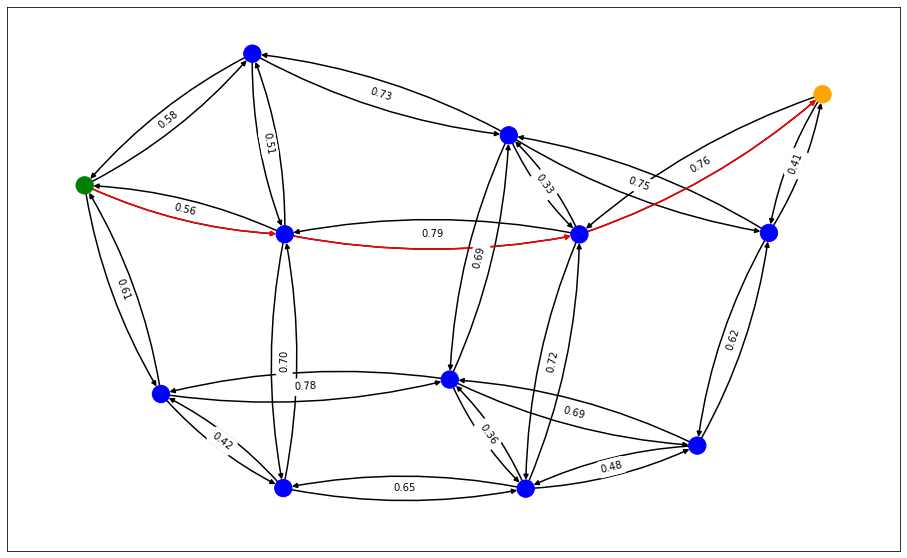

In [18]:
draw_graph(*make_graph())

## Formatting the input

The next step will be to take a nx.Graph object and convert it into a numeric format interpretable by a machine learning model. In our case, we need

- input edge properties: the (euclidean) distance between two nodes (in the 2D layout)
- input node properties: classes "start", "finish" and "other"
- output edge properties: binary labels that are $1$ if and only if the edge is part of a shortest path

Let $V$ be a $n\times 3$ matrix with a one hot encoding of the 3 input classes and $E$ be a $m\times 1$ vector with the distances of all edges.

Given $s,t$, we want to predict $P(e \in P_{s,t}^* \mid V, E)$ for all edges $e$ and a shortest path $P_{s,t}^*$. For simplicity we assume that the shortest path is unique, which may not be the case in real world scenarios.

In [88]:
#train on small graphs for speed
NUM_NODES_TRAIN = (13,24)
#test on larger graphs to validate generalization
NUM_NODES_VAL = (18,30) 
BATCH_SIZE = 8


def convert_graph_to_input_target(G, G_target):
    
    n = G.number_of_nodes()
    m = G.number_of_edges()
    
    input_nodes = np.zeros((n, 3))
    input_nodes[:,1] = [s for _,s in G.nodes.data("start")]
    input_nodes[:,2] = [t for _,t in G.nodes.data("target")]
    input_nodes[:,0] = 1 - input_nodes[:,1] - input_nodes[:,2]
    
    input_edges = np.zeros((m, 1))
    input_edges[:,0] = [d for _,_,d in G.edges.data("distance")]
    
    path_probs = np.zeros((m, 1))
    path_probs[:,0] = [p for _,_,p in G_target.edges.data("shortest_path")]
    
    incidence_matrix = nx.incidence_matrix(G, oriented=True)
    
    #scipy sparse matrix to tensorflow spare matrix
    coo = incidence_matrix.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    
    #incidence_matrix_senders = tf.SparseTensor(indices[coo.data == 1],
    #                                           tf.ones(m),
    #                                           dense_shape=(n,m))
    #incidence_matrix_receivers = tf.SparseTensor(indices[coo.data == -1],
    #                                           tf.ones(m),
    #                                           dense_shape=(n,m))
    
    input_dict = {
        "input_nodes" : np.expand_dims(input_nodes, 0),
        "input_edges" : np.expand_dims(input_edges, 0),
        "incidence_matrix_senders" : tf.expand_dims(incidence_matrix.todense() == 1, 0),
        "incidence_matrix_receivers" : tf.expand_dims(incidence_matrix.todense() == -1, 0)
    }
    target_dict =  {
        "path_probs" : np.expand_dims(path_probs, 0)
    }
    return input_dict, target_dict

# we do not use a global property in our graph
# therefore, we can simply merge all graphs in a batch into a large graph 
# message passing without a global property is independet for connected components
def sample_batch(num_nodes_minmax, batch_size=BATCH_SIZE, draw=False):
    batch_graphs = []
    batch_target_graphs = []
    batch_pos = {}
    n = 0
    div = int(np.sqrt(batch_size))
    for i in range(batch_size):
        g,gt,pos = make_graph(*num_nodes_minmax)
        mapping = {j : n+j for j in pos}
        g = nx.relabel_nodes(g, mapping)
        gt = nx.relabel_nodes(gt, mapping)
        batch_graphs.append(g)
        batch_target_graphs.append(gt)
        offset = np.array([i%div, i/div])
        batch_pos.update({n+j : offset*3+p for j,p in pos.items()})
        n += g.number_of_nodes()
    batch_graph = nx.compose_all(batch_graphs)
    batch_target_graph = nx.compose_all(batch_target_graphs)
    if draw:
        draw_graph(batch_graph, batch_target_graph, batch_pos)
    return convert_graph_to_input_target(batch_graph, batch_target_graph)


class SampleGenerator(keras.utils.Sequence):

    def __init__(self, num_nodes_minmax, epoch_len):
        self.num_nodes_minmax = num_nodes_minmax
        self.epoch_len = epoch_len

    def __len__(self):
        return self.epoch_len #number of gradient descent steps per epoch

    def __getitem__(self, _index):
        return sample_batch(self.num_nodes_minmax)
    

train_gen = SampleGenerator(NUM_NODES_TRAIN, 500)
val_gen = SampleGenerator(NUM_NODES_VAL, 10)

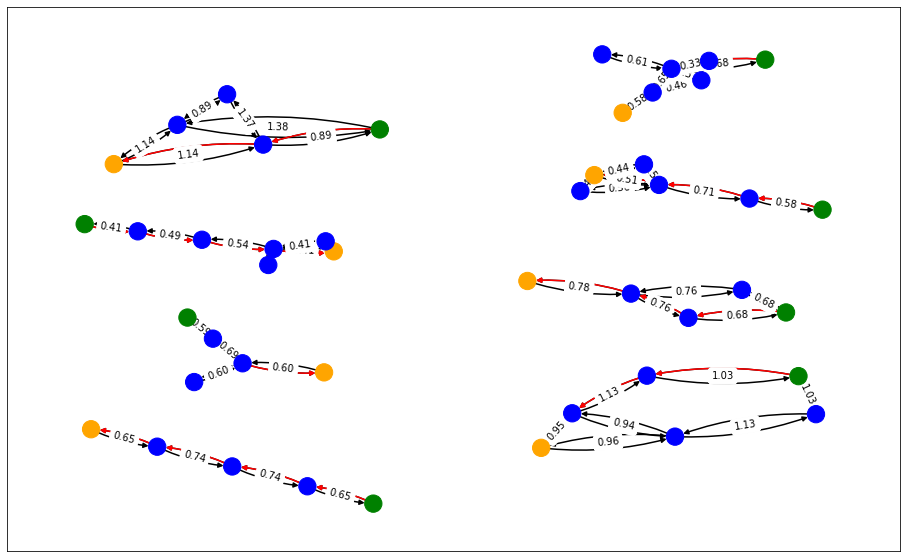

In [89]:
_=sample_batch((5,8), batch_size=8, draw=True) #a test batch of 8 small graphs

Note: The y axis was scaled to display the graphs.

## Define the network

Here we use simple 2 layer MLPs with relu activations followed by a layer normalization as message/update functions.

The GNN gets $n$ nodes, $m$ edges and incidence matrices as input.

In our model, we can use incidence matrices to implement the message passing. We expect these matricies to be sparse and use the appropriate API: https://www.tensorflow.org/guide/sparse_tensor.

In [72]:
#a feedforward layer
def make_ff_layer(config):
    return keras.Sequential([
            layers.Dense(config["latent_dim"], activation="relu"),
            layers.Dense(config["latent_dim"])])

def make_GNN(config):
    
    #define the inputs
    #we use a batch size of 1 since we implemented batching
    #by using the compound graph
    V = keras.Input(shape=(None,3), name="input_nodes", batch_size=1) 
    E = keras.Input(shape=(None,1), name="input_edges", batch_size=1) 
    Is = keras.Input(shape=(None,None), name="incidence_matrix_senders", 
                      batch_size=1) 
    Ir = keras.Input(shape=(None,None), name="incidence_matrix_receivers", 
                      batch_size=1) 
    
    node_encoder = make_ff_layer(config)
    edge_encoder = make_ff_layer(config)
    node_updater = make_ff_layer(config)
    edge_updater = make_ff_layer(config)
    edge_decoder = layers.Dense(1, activation="sigmoid")
    
    #step 1: encode
    #transform each node (dim=3) and edge (dim=1) to a latent embedding of "latent_dim"
    V_enc = node_encoder(V)
    E_enc = edge_encoder(E)
    
    path_probs = []
    
    #step 2: message passing
    for _ in range(config["message_passing_iterations"]):
        
        #for each node, sum outgoing and incoming edges (separately)
        V_Es = tf.matmul(Is, E_enc) 
        V_Er = tf.matmul(Ir, E_enc)
        #update all nodes based on current state and aggregated edge states
        V_concat = tf.concat([V_enc, V_Es, V_Er], axis=-1)
        V_enc = node_updater(V_concat)
        
        #get states of respective sender and receiver nodes for each edge
        E_Vs = tf.matmul(Is, V_enc, transpose_a=True)
        E_Vr = tf.matmul(Ir, V_enc, transpose_a=True)
        #update all edges
        E_concat = tf.concat([E_enc, E_Vs, E_Vr], axis=-1)
        E_enc = edge_updater(E_concat)
        
        #step 3: decode
        #in this case, we want to predict for each edge the probability of lying on a shortest path
        #we use sigmoid as activation
        path_probs.append(edge_decoder(E_enc))
    
    model = keras.Model(inputs=[V, E, Is, Ir], 
                        outputs=[layers.Lambda(lambda x: x, name="path_probs")(tf.stack(path_probs))])

    return model    

## Training

In [94]:
#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution() #prevents "Cannot convert a symbolic Keras input/output to a numpy array." error

config = {
    "message_passing_iterations" : 10,
    "latent_dim" : 32
}

NUM_EPOCHS = 20


GNN = make_GNN(config)

optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)

cee = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
acc = tf.keras.metrics.BinaryAccuracy()

def all_iterations_cee(y_true, y_pred):
    loss = 0
    for i in range(config["message_passing_iterations"]):
        loss += tf.reduce_mean(cee(y_true, y_pred[i])) #compute loss for all iterations
    return loss / config["message_passing_iterations"]

def last_iteration_binary_accuracy(y_true, y_pred):
    return acc(y_true, y_pred[-1])

GNN.compile(loss=all_iterations_cee, 
            optimizer=optimizer, 
            metrics={"path_probs" : last_iteration_binary_accuracy})

#takes ~10min on GPU
#change config for quick results on CPU 
history = GNN.fit(train_gen,
                    validation_data=val_gen,
                    epochs = NUM_EPOCHS,
                    verbose = 1)

Epoch 1/20
500/500 [==============================] - 24s 43ms/step - loss: 0.2542 - last_iteration_binary_accuracy: 0.9252 - val_loss: 0.1367 - val_last_iteration_binary_accuracy: 0.9268
Epoch 2/20
500/500 [==============================] - 21s 42ms/step - loss: 0.1521 - last_iteration_binary_accuracy: 0.9306 - val_loss: 0.1006 - val_last_iteration_binary_accuracy: 0.9345
Epoch 3/20
500/500 [==============================] - 21s 42ms/step - loss: 0.1244 - last_iteration_binary_accuracy: 0.9378 - val_loss: 0.0913 - val_last_iteration_binary_accuracy: 0.9413
Epoch 4/20
500/500 [==============================] - 21s 42ms/step - loss: 0.1116 - last_iteration_binary_accuracy: 0.9443 - val_loss: 0.0864 - val_last_iteration_binary_accuracy: 0.9470
Epoch 5/20
500/500 [==============================] - 21s 42ms/step - loss: 0.1149 - last_iteration_binary_accuracy: 0.9489 - val_loss: 0.0882 - val_last_iteration_binary_accuracy: 0.9504
Epoch 6/20
500/500 [==============================] - 21s 42

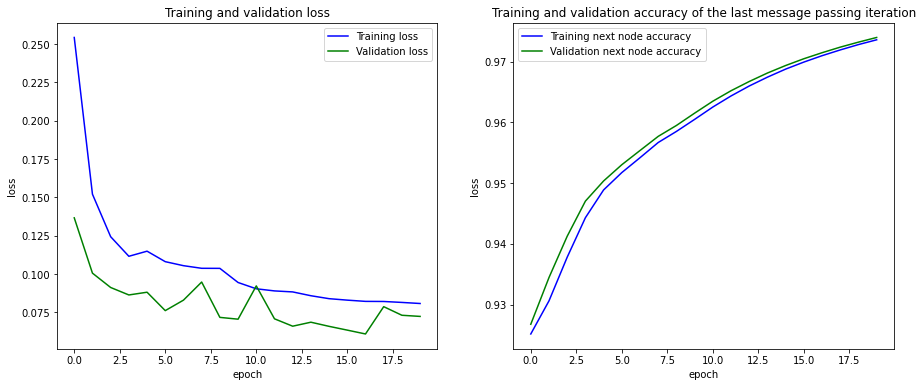

In [96]:
_, ax = plt.subplots(ncols = 2, figsize = (15, 6))

ax[0].plot(np.arange(NUM_EPOCHS), history.history["loss"], 'b', label = 'Training loss')
ax[0].plot(np.arange(NUM_EPOCHS), history.history["val_loss"], 'g', label = 'Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend();

ax[1].plot(np.arange(NUM_EPOCHS), history.history["last_iteration_binary_accuracy"], 'b', label = 'Training accuracy')
ax[1].plot(np.arange(NUM_EPOCHS), history.history["val_last_iteration_binary_accuracy"], 'g', label = 'Validation accuracy')
ax[1].set_title('Training and validation accuracy of the last message passing iteration')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
ax[1].legend();

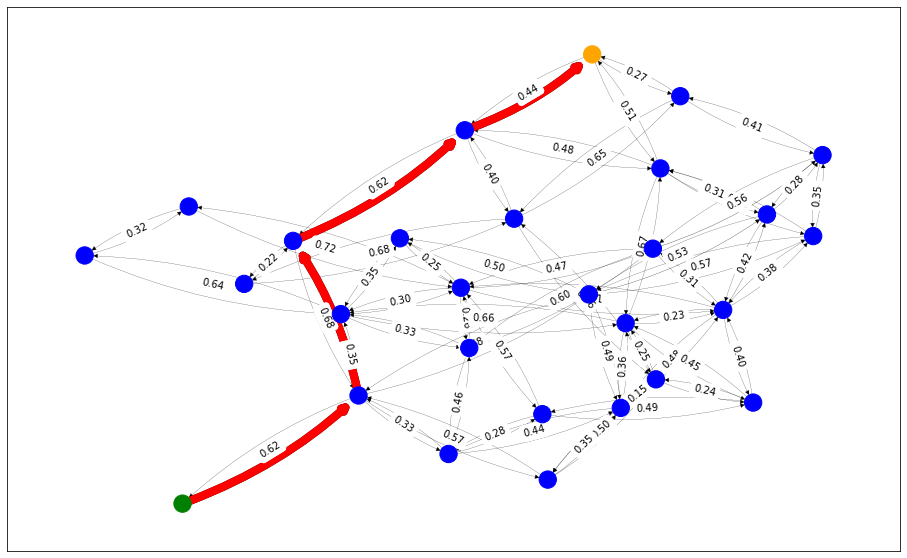

In [105]:
g, gt, pos = make_graph(18, 30)
inp, tar = convert_graph_to_input_target(g, gt)
path_probs = GNN(inp)

#thick edges correspond to large probabilities
#red edges mark the correct shortest path
#if multiple short paths with similar lengths exists, the model gets confused
#works well if the shortest path is unique
draw_graph(g, gt, pos, 0.2 + 8*tf.squeeze(path_probs[-1]))

# Question
Describe an approach that could fix the problem that occurs with multiple shortest paths in one graph.
Tip: Describe how to iteratively apply the trained model to the problem.